In [122]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils_CPU import *
from DAST_Network_CPU import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math

In [123]:
#Myscore function
def myScore(target, pred):
    print('target', target.shape)
    print('pred', pred.shape)
    Er = 100 * ((target - pred) / target)
    print(Er.shape)
    A = math.exp(-np.log(0.5) * (Er / 5)) if Er <=0 else math.exp(np.log(0.5) * (Er / 20))
    return A

In [124]:
def RMSE(target, pred):
    square_error = (target - pred) ** 2
    mse =  (torch.sum(square_error)) / len(target)
    rmse = mse ** 0.5
    return rmse

In [125]:
def MAE(target, pred):
    pred = pred.detach().numpy()
    absolute_error = np.abs(target - pred)
    return torch.sum(absolute_error) / len(target)

In [126]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'

In [127]:
X_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_2000_40_1_X.npy')
Y_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_2000_40_1_Y.npy')
X_train, X_test = X_np[:1600], X_np[:2000]
Y_train, Y_test = Y_np[:1600], Y_np[:2000]
Y_train = np.reshape(Y_train, (len(Y_train), -1))
Y_test = np.reshape(Y_test, (len(Y_test), -1))

In [128]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [129]:
#Hyperparameters
FEATURE = 1
EMBEDD = 50
batch_size = 256
dim_val = FEATURE
dim_attn = EMBEDD
dim_val_t = FEATURE
dim_attn_t = EMBEDD
dim_val_s = FEATURE
dim_attn_s = EMBEDD
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 1
lr = 1e-5
epochs = 15
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = FEATURE

In [130]:
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=False)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [131]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [132]:
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []

In [133]:
for epoch in range(epochs):
    #training
    model.train()
    loop = tqdm(train_loader, leave=True)
    for i,(batch_X, batch_Y) in enumerate(loop):
        out = model(batch_X)
        loss = criterion(out, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    for j ,(batch_x,batch_y) in enumerate(test_loader):
        prediction = model(batch_x)
        # prediction[prediction<0] = 0
        prediction_list.append(prediction)

    out_batch_pre = torch.cat(prediction_list)
    rmse_loss = RMSE(Y_test, out_batch_pre, )
    mae_loss = MAE(Y_test, out_batch_pre, )
    test_loss = criterion(out_batch_pre, Y_test)
    test_loss_list.append(test_loss.detach().numpy())
    print('rmse_loss = ', rmse_loss.item(),
            'mae_loss = ', mae_loss.item(),
            'mse_loss = ', test_loss.item())

100%|██████████| 7/7 [00:00<00:00, 27.04it/s]


epoch =  0 train_loss =  0.18503910146786698
rmse_loss =  0.5000601410865784 mae_loss =  0.4184151589870453 mse_loss =  0.25006017088890076


100%|██████████| 7/7 [00:00<00:00, 33.26it/s]


epoch =  1 train_loss =  0.18501809999413257
rmse_loss =  0.500011682510376 mae_loss =  0.4183657765388489 mse_loss =  0.25001171231269836


100%|██████████| 7/7 [00:00<00:00, 29.06it/s]


epoch =  2 train_loss =  0.18499707919545472
rmse_loss =  0.49996283650398254 mae_loss =  0.41831594705581665 mse_loss =  0.24996283650398254


100%|██████████| 7/7 [00:00<00:00, 31.09it/s]


epoch =  3 train_loss =  0.1849760474204751
rmse_loss =  0.4999139606952667 mae_loss =  0.4182661175727844 mse_loss =  0.24991397559642792


100%|██████████| 7/7 [00:00<00:00, 32.72it/s]


epoch =  4 train_loss =  0.18495503596828453
rmse_loss =  0.49986517429351807 mae_loss =  0.41821643710136414 mse_loss =  0.24986520409584045


100%|██████████| 7/7 [00:00<00:00, 32.52it/s]


epoch =  5 train_loss =  0.1849340508564464
rmse_loss =  0.49981650710105896 mae_loss =  0.41816678643226624 mse_loss =  0.24981655180454254


100%|██████████| 7/7 [00:00<00:00, 30.36it/s]


epoch =  6 train_loss =  0.1849130980162026
rmse_loss =  0.4997679889202118 mae_loss =  0.41811737418174744 mse_loss =  0.24976803362369537


100%|██████████| 7/7 [00:00<00:00, 32.80it/s]


epoch =  7 train_loss =  0.1848921779414273
rmse_loss =  0.4997195899486542 mae_loss =  0.418067991733551 mse_loss =  0.24971966445446014


100%|██████████| 7/7 [00:00<00:00, 32.76it/s]


epoch =  8 train_loss =  0.1848712899881075
rmse_loss =  0.49967125058174133 mae_loss =  0.41801872849464417 mse_loss =  0.24967136979103088


100%|██████████| 7/7 [00:00<00:00, 33.00it/s]


epoch =  9 train_loss =  0.1848504321067594
rmse_loss =  0.49962303042411804 mae_loss =  0.41796964406967163 mse_loss =  0.2496231645345688


100%|██████████| 7/7 [00:00<00:00, 32.90it/s]


epoch =  10 train_loss =  0.1848296034588273
rmse_loss =  0.49957484006881714 mae_loss =  0.4179205298423767 mse_loss =  0.24957501888275146


100%|██████████| 7/7 [00:00<00:00, 32.52it/s]


epoch =  11 train_loss =  0.18480879930263786
rmse_loss =  0.499526709318161 mae_loss =  0.4178715944290161 mse_loss =  0.2495269477367401


100%|██████████| 7/7 [00:00<00:00, 32.86it/s]


epoch =  12 train_loss =  0.18478801864030475
rmse_loss =  0.49947863817214966 mae_loss =  0.41782256960868835 mse_loss =  0.24947892129421234


100%|██████████| 7/7 [00:00<00:00, 32.94it/s]


epoch =  13 train_loss =  0.1847672601757875
rmse_loss =  0.4994306266307831 mae_loss =  0.41777369379997253 mse_loss =  0.24943093955516815


100%|██████████| 7/7 [00:00<00:00, 31.91it/s]


epoch =  14 train_loss =  0.1847465207356782
rmse_loss =  0.4993826448917389 mae_loss =  0.41772475838661194 mse_loss =  0.24938301742076874


In [134]:
z = np.reshape(out_batch_pre.detach().numpy(), (-1))
z = z.tolist()

In [135]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

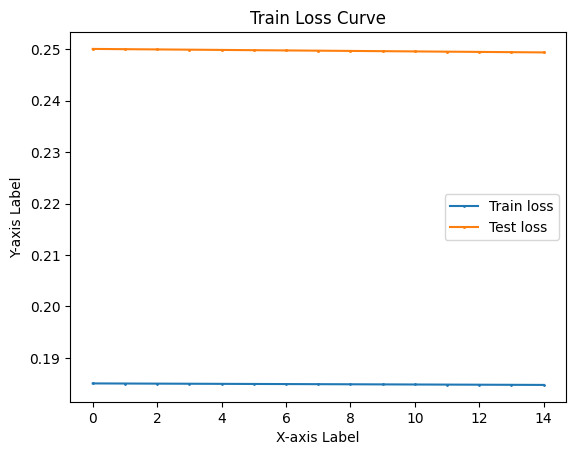

In [136]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(train_loss_list, label='Train loss', marker='o', markersize=1)
plt.plot(test_loss_list, label='Test loss', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

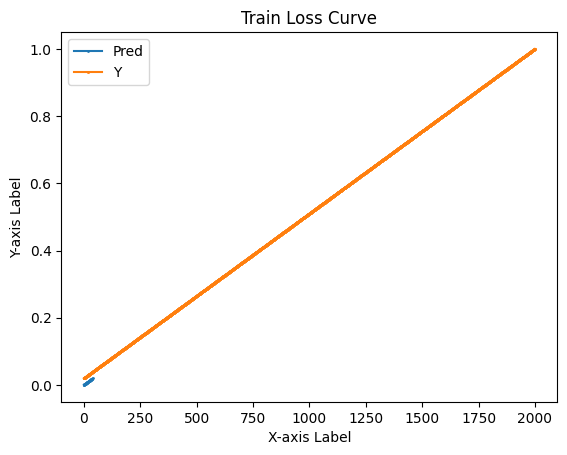

In [137]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_np[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_np, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

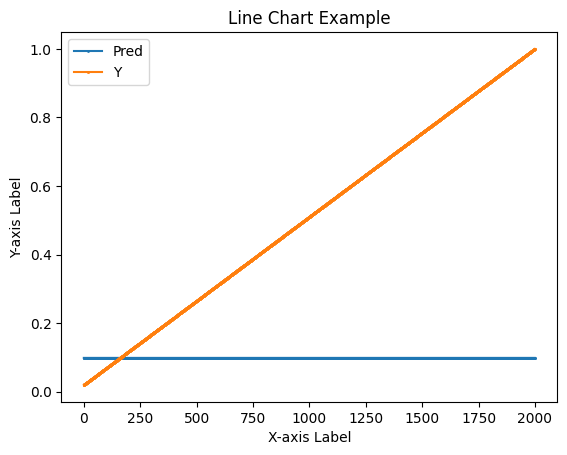

In [138]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(z, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Line Chart Example')

# Adding a legend
plt.legend()

# Display the plot
plt.show()